PHASE 5
1. Train Yield Prediction Model (Regression).
2. Proper Regression evaluation. (RMSE, MAE,R^2).
3. Actual vs Predicted plots.
4. Clear explanation of reslts.
5. Complete the second module of the unified system.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [2]:
df = pd.read_csv("../data/raw/crop_yield.csv")
df.head()


,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,1997,Kharif,Assam,796.0,22,2051.4,75755.32,246.76,0.238333
3,Coconut,1997,Whole Year,Assam,19656.0,126905000,2051.4,1870661.52,6093.36,5238.051739
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,2051.4,165500.63,539.09,0.420909


Load librariesand dataset.

In [3]:
y_yield = df["Yield"]
X_yield = df.drop(columns=["Yield", "Production"])


Define features and target.
1. Target - Yield.
2. Features - Yield, Production --> removed to avoid data leakage

In [4]:
cat_cols = ["Crop", "Season", "State"]
num_cols = [col for col in X_yield.columns if col not in cat_cols]


Identify categorical and numerical columns.

In [5]:
Xy_train, Xy_test, yy_train, yy_test = train_test_split(
    X_yield,
    y_yield,
    test_size=0.2,
    random_state=42
)


Train/Test split.
No stratification needed for regression.

In [6]:
preprocess_yield = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)


In [7]:
Xy_train_enc = preprocess_yield.fit_transform(Xy_train)
Xy_test_enc = preprocess_yield.transform(Xy_test)


Preprocessing pipeline - fit only on training data.

In [8]:
lr_model = LinearRegression()
lr_model.fit(Xy_train_enc, yy_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [9]:
lr_preds = lr_model.predict(Xy_test_enc)

lr_mse = mean_squared_error(yy_test, lr_preds)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(yy_test, lr_preds)
lr_r2 = r2_score(yy_test, lr_preds)

lr_rmse, lr_mae, lr_r2


(np.float64(389.68080932458247), 63.88493035137237, 0.8104798078497211)

R^2=0.81 --> Model explains about 81% of the variance in crop yield.
MAE=64 --> On average, predictions are off by 64 yield units.
RMSE=390 --> RMSE is larger than MAE as it penalizes large errors more.

CONCLUSION: Linear regression works well, but is limted by non-linearity, skewed data, and interaction between features.

In [10]:
rf_yield_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_yield_model.fit(Xy_train_enc, yy_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [14]:
import joblib
import os

os.makedirs("../models", exist_ok=True)

joblib.dump(rf_yield_model, "../models/yield_model.pkl")
joblib.dump(preprocess_yield, "../data/processed/preprocess_yield.pkl")


['../data/processed/preprocess_yield.pkl']

FInal model: Random Forest Regressor. 
Performs much better on skewed, nonlinear data.


In [11]:
rf_preds = rf_yield_model.predict(Xy_test_enc)

rf_mse = mean_squared_error(yy_test, rf_preds)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(yy_test, rf_preds)
rf_r2 = r2_score(yy_test, rf_preds)

rf_rmse, rf_mae, rf_r2


(np.float64(125.24581585003489), 9.41351824607496, 0.9804221993001577)

1. R^2 = 0.98 --> the model explains 98% of the variance in yield. Indicates that model captures nonlinear relationships very well.
2. MAE=9.4 --> On average, predictions are off by 9 yield units, much better than linear regression where MAE=64
3. RMSE=125 --> Penalizes large errors, confirms robustness of the model.

Linear Regression was used as a baseline model. Due to the nonlinear and skewed nature of agricultural yield data, Random Forest Regressor significantly outperformed the baseline across all evaluation metrics.


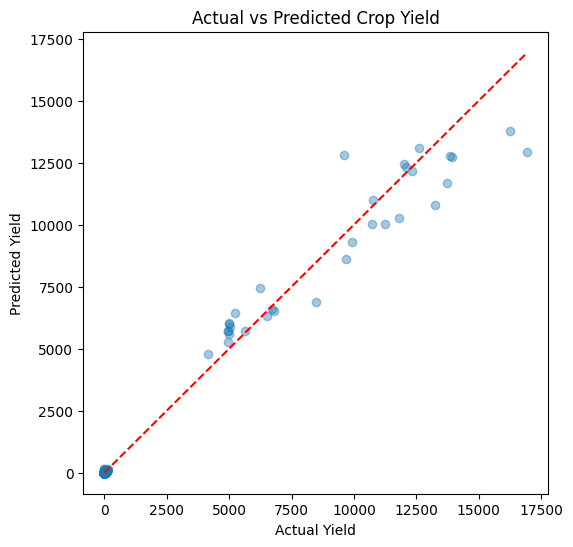

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(yy_test, rf_preds, alpha=0.4)
plt.plot([yy_test.min(), yy_test.max()],
         [yy_test.min(), yy_test.max()],
         color="red", linestyle="--")
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs Predicted Crop Yield")
plt.show()


Actual vs Predicted plot.
1. Points lie close to the 45° diagonal line very little vertical spread
2. No obvious systematic deviation

Predicted yield ≈ Actual yield for most samples.

This visually confirms:
1. High R² (~0.98)
2. Low MAE (~9)
3. Good generalization on unseen test data

In [13]:
"Production" in X_yield.columns


False

CONCLUSION:
We trained a regression model to predict crop yield using environmental and management features. Linear Regression was used as a baseline, and Random Forest Regressor was selected as the final model due to its ability to capture nonlinear relationships and handle skewed agricultural data.